In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request

In [17]:
# Fetching and Loading Data
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

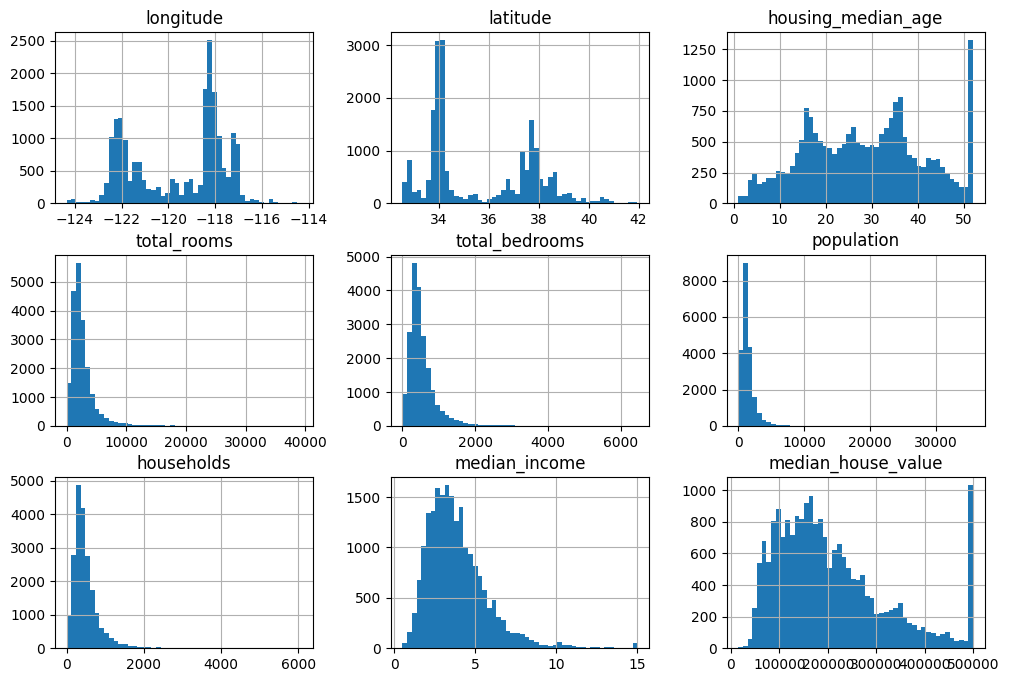

In [18]:
# Data Visualization
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [19]:
# Get Random Test Data Manually (0.2 == 20%) (Dont Have To run)
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2) 

In [20]:
# Another Implementation of getting Data with 1:5 Ratio (test_set:data) (Dont Have To run)

from zlib import crc32

# Function to check if an identifier belongs to the test set
def is_id_in_test_set(identifier, test_ratio):
    # Hash the identifier using crc32 and check if it's below the test_ratio threshold
    return crc32(np.int64(identifier)) < test_ratio * 2**32

# Function to split data into training and test sets based on hashed IDs
def split_data_with_id_hash(data, test_ratio, id_column):
    # Extract the column containing unique IDs
    ids = data[id_column]
    # Apply the is_id_in_test_set function to each ID
    # Returns True for test set rows, False for training set rows
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    # Use Boolean indexing to split the data into training and test sets
    return data.loc[~in_test_set], data.loc[in_test_set]

# Reset index to create a unique identifier for each row in the dataset
housing_with_id = housing.reset_index()

# Split the dataset into 80% training and 20% test sets using the index as the ID column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, id_column="index")


In [21]:
# Split data (20%:80%) Using ScikitLearn (Run)

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

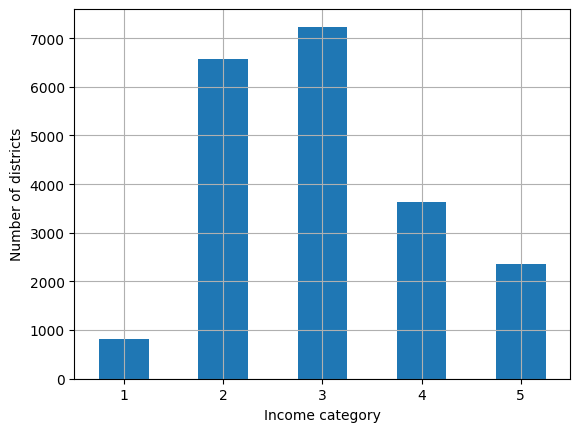

In [22]:
# Represent Various Categories of Incomes (bins)

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [23]:
# Stratified Sampling (Split the whole dataset with respect to each bins)

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [24]:
# Will split and store the data (test:train) (20:80)
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [25]:
# Print to look if it work as expected
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [26]:
#  removes the column income_cat from both the training and testing datasets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
# Copy Original Training set
housing = strat_train_set.copy()

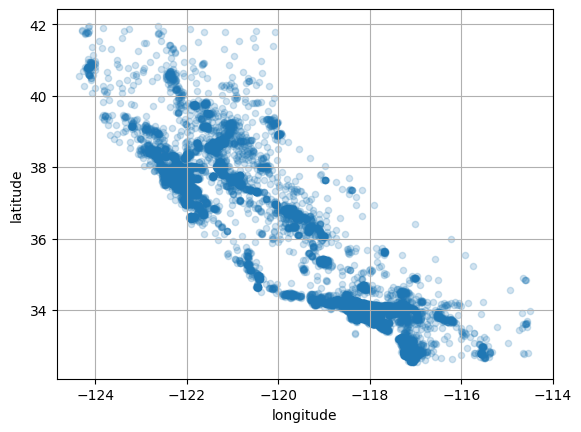

In [28]:
# California plot
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.show()

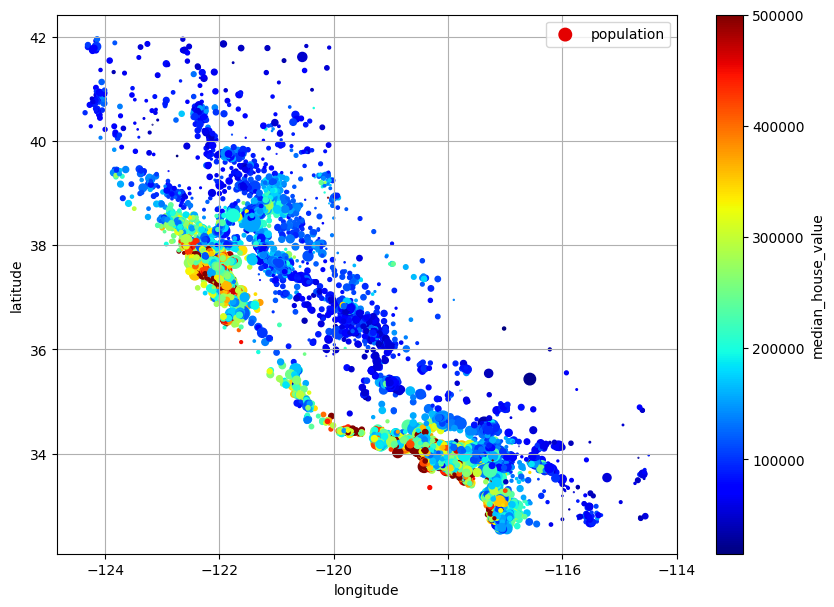

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [30]:
# Look for Correlations
numeric_data = housing.select_dtypes(include=[np.number]) # Only pick numeric data
corr_matrix = numeric_data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

In [31]:
# Making Other Data Useful by combining
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [32]:
# Copy the data to prepare some ML algorithms (for safety and all various reason)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
# Clean Data
# Fix the bedroom missing attributes (use median)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [36]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [38]:
# Handling Text and Categoral Attributes
# Check
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [41]:
# Convert Text to nums (1,2,3,4) (Not Ideal Don't RUN)

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8] # check

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [46]:
# one-hot encoding (More Ideal RUN) (This Display the data better)
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])